In [1]:
# module imports
import warnings
warnings.filterwarnings(action="ignore")
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgbm
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import time

In [2]:
# removes prefix of the sequence
def remove_prefix(text: str, prefix: str) -> str:
    if text.startswith(prefix):
        return text[len(prefix):]
    raise ValueError(prefix)

# removes suffix of the sequence
def remove_suffix(text: str, suffix: str) -> str:
    if text.endswith(suffix):
        return text[len(suffix):]
    raise ValueError(suffix)

In [3]:
# global variables to assist preprocessing
PREFIX = 'TGCATTTTTTTCACATC'
SUFFIX = 'GGTTACGGCTGTT'
MAX_SEQ_LEN = 142 - len(PREFIX) - len(SUFFIX) # 112

In [4]:
# load, encode training data
encoder = LabelEncoder()
X_train = []
y_train = []

with open('data/train_sequences.txt', 'r') as f:
    for i, line in enumerate(tqdm(f.readlines())):
        seq, expr = line.split('\t')
        seq = remove_suffix(remove_prefix(seq, PREFIX), SUFFIX)
        encoder.fit([_ for _ in seq])
        vec = encoder.transform([_ for _ in seq])
        expr = float(expr)
        X_train.append(vec)
        y_train.append(expr)

100%|██████████| 6739258/6739258 [11:03<00:00, 10151.83it/s]


In [5]:
# load, encode testing data
X_test = []

with open('data/test_sequences.txt', 'r') as f:
    for i, line in enumerate(tqdm(f.readlines())):
        seq, expr = line.split('\t')
        seq = remove_suffix(remove_prefix(seq, PREFIX), SUFFIX)
        vec = encoder.transform([_ for _ in seq])
        X_test.append(vec)

100%|██████████| 71103/71103 [00:03<00:00, 18798.39it/s]


In [6]:
# check vector stack shape for training data
print(np.unique(list(map(len, X_train))))

[ 48  49  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104 105 106 107 108 109 110 111 112]


In [7]:
# padding => this is probably a poor method, but can't think of another alternative
for i, vector in enumerate(X_train):
    while(len(vector)) < MAX_SEQ_LEN:
        vector = list(vector)
        vector.append(4)
    X_train[i] = vector

In [29]:
# check vector stack shape for training data
print(np.unique(list(map(len, X_train))))

[112]


In [9]:
# check vector stack shape for testing data
print(np.unique(list(map(len, X_test))))

[80]


In [8]:
# split data, cast to numpy
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, shuffle=True, random_state=42)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

In [9]:
# create the datasets
lgb_train = lgbm.Dataset(X_train, y_train, free_raw_data=False)
lgb_eval = lgbm.Dataset(X_valid, y_valid, reference=lgb_train, free_raw_data=False)

In [45]:
# baseline parameters
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'l2',
    'num_leaves': 255,
    'force_row_wise': True,
    'seed': 42,
    'verbose': -1,
    'bagging_fraction': 0.8,
    'feature_fraction': 0.9,
    'max_depth': 8
}

In [46]:
# assign positions as features
feature_name = [f'POS_{col}' for col in range(MAX_SEQ_LEN)]

In [47]:
print('Starting training...')
gbm = lgbm.train(params,
                lgb_train,
                valid_sets=lgb_train,
                feature_name=feature_name,
                categorical_feature=[MAX_SEQ_LEN]
                )
print('Finished training...')

Starting training...
[1]	training's l2: 106.183
[2]	training's l2: 86.9909
[3]	training's l2: 71.4437
[4]	training's l2: 58.8521
[5]	training's l2: 48.6491
[6]	training's l2: 40.3828
[7]	training's l2: 33.6868
[8]	training's l2: 28.2588
[9]	training's l2: 23.863
[10]	training's l2: 20.2989
[11]	training's l2: 17.4071
[12]	training's l2: 15.0631
[13]	training's l2: 13.1629
[14]	training's l2: 11.6207
[15]	training's l2: 10.3684
[16]	training's l2: 9.35194
[17]	training's l2: 8.52491
[18]	training's l2: 7.85168
[19]	training's l2: 7.30535
[20]	training's l2: 6.86002
[21]	training's l2: 6.49493
[22]	training's l2: 6.19784
[23]	training's l2: 5.95523
[24]	training's l2: 5.75627
[25]	training's l2: 5.59274
[26]	training's l2: 5.4575
[27]	training's l2: 5.34453
[28]	training's l2: 5.2524
[29]	training's l2: 5.17345
[30]	training's l2: 5.10793
[31]	training's l2: 5.05416
[32]	training's l2: 5.00656
[33]	training's l2: 4.96568
[34]	training's l2: 4.93158
[35]	training's l2: 4.90099
[36]	traini

In [48]:
def save_model(gbm, num_boost_round, step=1):
    print('Saving model...')
    gbm.save_model(f'models/model_{num_boost_round * step}.txt')

# save baseline model to directory
save_model(gbm, num_boost_round=100)

Saving model...


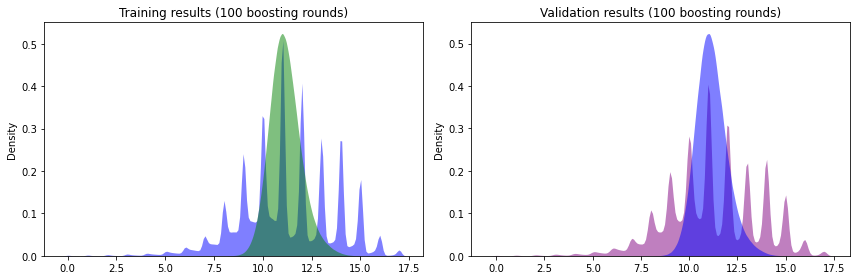

In [49]:
def create_density_chart(y_train, y_valid, train_pred, valid_pred, step):
    palette = sns.cubehelix_palette(light=.8, n_colors=6)
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    sns.kdeplot(y_train, ax=axs[0], label='y', fill=True, common_norm=False, palette=palette, alpha=.5, linewidth=0, color='blue')
    sns.kdeplot(train_pred, ax=axs[0], fill=True, common_norm=False, palette=palette, alpha=.5, linewidth=0, color='green')
    sns.kdeplot(y_valid, ax=axs[1], label='y', fill=True, common_norm=False, palette=palette, alpha=.5, linewidth=0, color='purple')
    sns.kdeplot(valid_pred, ax=axs[1], fill=True, common_norm=False, palette=palette, alpha=.5, linewidth=0, color='blue')
    axs[0].set_title(f'Training results ({100 * step} boosting rounds)')
    axs[1].set_title(f'Validation results ({100 * step} boosting rounds)')
    fig.tight_layout()
    fig.savefig(fname=f'results/model_result_000{step}')

create_density_chart(y_train=y_train, y_valid=y_valid, train_pred=gbm.predict(X_train), valid_pred=gbm.predict(X_valid), step=1)

In [50]:
print(f"R-squared (train): {r2_score(y_train, gbm.predict(X_train))}")
print(f"R-squared (validation): {r2_score(y_valid, gbm.predict(X_valid))}")

R-squared (train): 0.22148605357720386
R-squared (validation): 0.2157437664922397


In [51]:
def extend_model(lgbm, num_boost_round, step):
    gbm = lgbm.train(params,
                lgb_train,
                num_boost_round=num_boost_round,
                init_model=f'models/model_{num_boost_round * step}.txt',
                valid_sets=lgb_eval)
    step += 1
    save_model(gbm, num_boost_round=100, step=step)

Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's l2: 4.0831
Saving model...


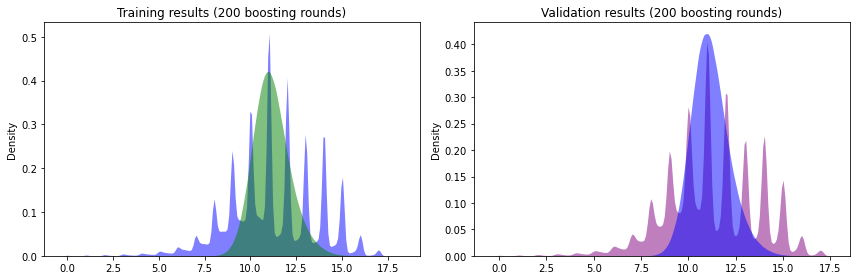

R-squared (train): 0.28164650445443173
R-squared (validation): 0.2725060184464244
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's l2: 3.91992
Saving model...


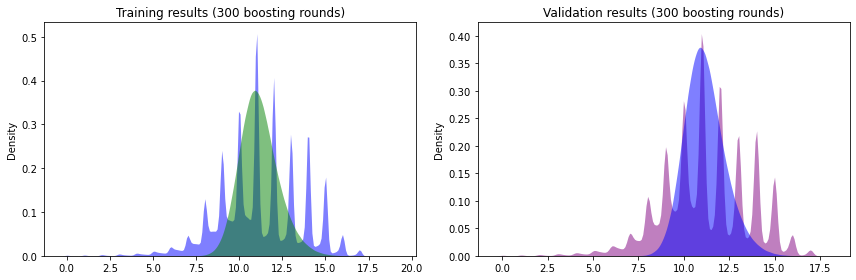

R-squared (train): 0.3136887113103405
R-squared (validation): 0.30158029957073285
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[400]	valid_0's l2: 3.8324
Saving model...


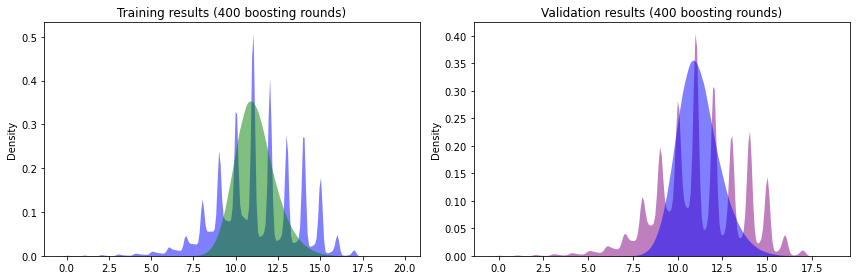

R-squared (train): 0.332280950888579
R-squared (validation): 0.3171749529028327
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 3.78343
Saving model...


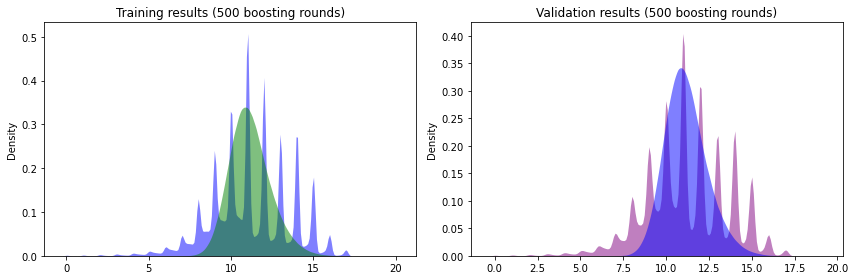

R-squared (train): 0.34411449311164943
R-squared (validation): 0.3258994029092195


In [54]:
# training fragment
step, num_boost_round = 1, 100
while step < 5:
    gbm = lgbm.Booster(model_file=f'models/model_{100 * step}.txt')
    gbm = lgbm.train(params,
                    lgb_train,
                    init_model=f'models/model_{num_boost_round * step}.txt',
                    valid_sets=lgb_eval,
                    callbacks=[# lgbm.reset_parameter(bagging_fraction=[0.6] * 25 + [0.8] * 25 + [0.9] * 50),
                               # lgbm.reset_parameter(feature_fraction=[0.6] * 25 + [0.8] * 25 + [0.9] * 50),
                               # lgbm.reset_parameter(learning_rate=lambda lr: 0.05 * 0.95 ** lr),
                               lgbm.early_stopping(5, verbose=True),
                               # lgbm.reset_parameter(bagging_fraction=[0.4] * 100)
                              ])
    step += 1
    save_model(gbm, num_boost_round=100, step=step)
    create_density_chart(y_train=y_train, y_valid=y_valid, train_pred=gbm.predict(X_train), valid_pred=gbm.predict(X_valid), step=step)
    plt.show()
    print(f"R-squared (train): {r2_score(y_train, gbm.predict(X_train))}")
    print(f"R-squared (validation): {r2_score(y_valid, gbm.predict(X_valid))}")

In [56]:
# configure parameters
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'l2',
    'num_leaves': 2047,
    'force_row_wise': True,
    'seed': 42,
    'verbose': -1,
    'bagging_fraction': 0.8,
    'max_depth': 11
}

Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[600]	valid_0's l2: 3.7271
Saving model...


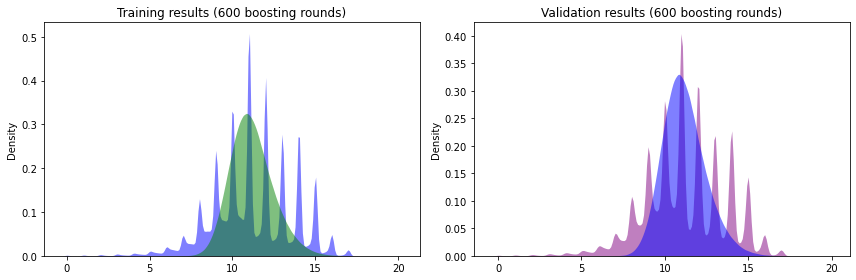

R-squared (train): 0.3821822247541776
R-squared (validation): 0.33593550234548697
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[700]	valid_0's l2: 3.70665
Saving model...


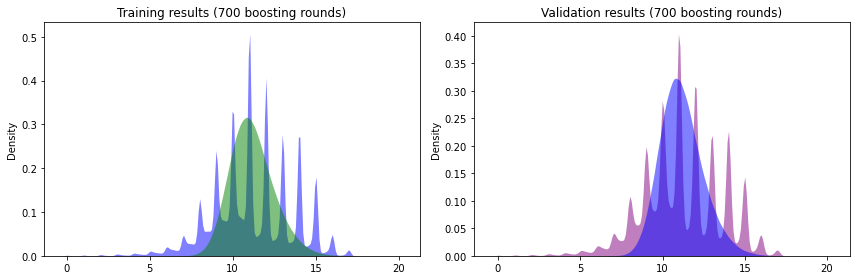

R-squared (train): 0.410396383273663
R-squared (validation): 0.3395799324026689
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[785]	valid_0's l2: 3.69782
Saving model...


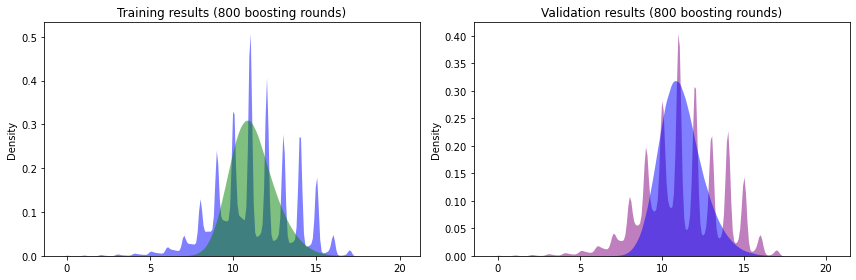

R-squared (train): 0.43389251392463835
R-squared (validation): 0.34115197601879454
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[831]	valid_0's l2: 3.69382
Saving model...


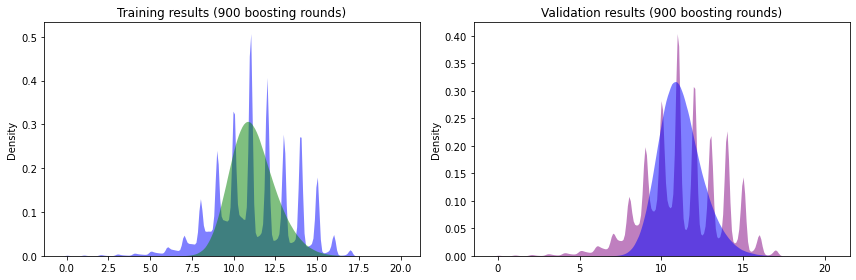

R-squared (train): 0.44736724871380884
R-squared (validation): 0.341864817482357
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[896]	valid_0's l2: 3.6901
Saving model...


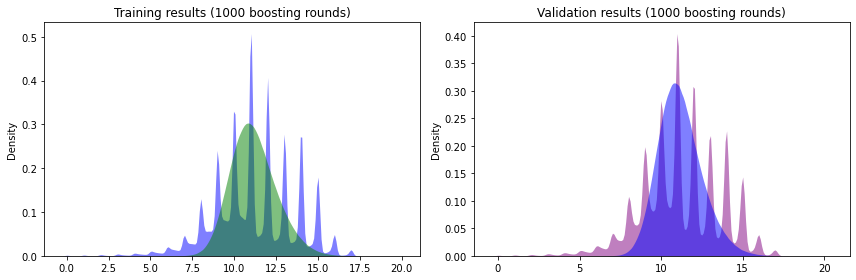

R-squared (train): 0.46401716212302446
R-squared (validation): 0.34252808923365163


In [57]:
# no overfitting, increase leaf count
step, num_boost_round = 5, 100
while step < 10:
    gbm = lgbm.Booster(model_file=f'models/model_{100 * step}.txt')
    gbm = lgbm.train(params,
                    lgb_train,
                    init_model=f'models/model_{num_boost_round * step}.txt',
                    valid_sets=lgb_eval,
                    callbacks=[# lgbm.reset_parameter(bagging_fraction=[0.6] * 25 + [0.8] * 25 + [0.9] * 50),
                               # lgbm.reset_parameter(feature_fraction=[0.6] * 25 + [0.8] * 25 + [0.9] * 50),
                               # lgbm.reset_parameter(learning_rate=lambda lr: 0.05 * 0.95 ** lr),
                               lgbm.early_stopping(5, verbose=True),
                               # lgbm.reset_parameter(bagging_fraction=[0.4] * 100),
                               # lgbm.reset_parameter(max_depth=[11] * num_boost_round),
                               # lgbm.reset_parameter(num_leaves=[2047] * num_boost_round)
                              ])
    step += 1
    save_model(gbm, num_boost_round=100, step=step)
    create_density_chart(y_train=y_train, y_valid=y_valid, train_pred=gbm.predict(X_train), valid_pred=gbm.predict(X_valid), step=step)
    plt.show()
    print(f"R-squared (train): {r2_score(y_train, gbm.predict(X_train))}")
    print(f"R-squared (validation): {r2_score(y_valid, gbm.predict(X_valid))}")